# TASK 3 —— PRICE DEPRECIATION ANALYSIS
Given that we already have used car makes, models and price data, we are thinking about the degree of depreciation of different car makes and models. Are certain makes of cars easy to discount? Or the longer it is used, the easier it is to discount ? Out of curiosity about these, we use data to verify our conjecture. Through the crawler, we obtained the new car data from sgcarmart.com. The results of our analysis may provide some references for car manufacturers, as well as some suggestions for buyers. 
### Here is an overview of what we have done:
* **1. Data Preprocessing**
* **2. Data Analysis**
* **3. Modelling**

## Import Denpendencies

In [2]:
import pandas as pd
import re
from fuzzywuzzy import fuzz
import numpy as np
import matplotlib.pyplot as plt

## Load Data & Data Overview
**Dataset Introduction:**
* Old car data, training data from task 1.
* New car data, downloaded from sgcarmart.com, total number of records was 456.

In [3]:
# load old car data
df_old = pd.read_csv('data/train.csv')
df_old.reset_index()
# load new car data
df_new = pd.read_csv('data/new_car.csv')

### Overview of the new car data

In [4]:
df_new.head()

,name,model,price
0,Hyundai Tucson,1.6 DCT Turbo Sunroof (A),"$171,999$15,900 /yr"
1,Hyundai Tucson,1.6 DCT Turbo S Sunroof (A),"$176,999$16,200 /yr"
2,Kia Stonic Mild Hybrid,1.0T EX (A),"$99,999$9,700 /yr"
3,Kia Stonic Mild Hybrid,1.0T SX (A),"$103,999$10,100 /yr"
4,SKODA Octavia Mild Hybrid,1.5 TSI e`TEC Ambition (A),"$63,900(w/o COE)"


### Overview of the old car data

In [5]:
df_old.head()

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,73000.0,45330.0,50462.0,NaN,NaN,uncategorized,"5 doors gt, powerful and fuel efficient 2.0l t...","bmw i-drive, navigation, bluetooth/aux/usb inp...",NaN,71300.0
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,110112.0,27502.0,1376.0,NaN,25-jan-2035,uncategorized,low mileage unit. well maintained vehicle. vie...,factory radio setting. front recording camera....,NaN,43800.0
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,80000.0,27886.0,26041.0,NaN,NaN,uncategorized,responsive and fuel efficient 1.6l inline 4 cy...,dual electric/memory seats. factory fitted aud...,NaN,95500.0
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,9800.0,46412.0,56977.0,NaN,NaN,uncategorized,"1.5l inline-4 twin scroll turbocharged engine,...",64 colour ambient lighting. active parking ass...,NaN,197900.0
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,40000.0,20072.0,20101.0,NaN,NaN,uncategorized,"1.6l i-vtec engine, 123 bhp, earth dreams cvt ...","s/rims, premium leather seats, factory touch s...",NaN,103200.0


## 1. Data Preprocessing
* **1.1 Clean data**
* **1.2 Match new car data with old car data according to text similarity.**

### 1.1 a) Extract the real price of the new car

In [6]:
def extract_price(x):
    if '$' in str(x):
        price = str(x).split('$')[1]
        price = price.split('(')[0]
        price = int(price.replace(',', ''))
    elif '¥' in str(x):
        price = str(x).split('¥')[1]
        price = int(price.replace(',', ''))
    else:
        price = int(x)
    return price

### 1.1 b) Remove bracket in the model of the new car

In [7]:
def remove_bracket(x):
    return re.sub(r'\(.*\)','', x)

In [8]:
df_new = df_new[df_new.price != 'POA']
df_new['new_price'] = df_new.price.apply(lambda x: extract_price(x))
df_new.model = df_new.model.apply(lambda x: remove_bracket(x))
df_new.head()

,name,model,price,new_price
0,Hyundai Tucson,1.6 DCT Turbo Sunroof,"$171,999$15,900 /yr",171999
1,Hyundai Tucson,1.6 DCT Turbo S Sunroof,"$176,999$16,200 /yr",176999
2,Kia Stonic Mild Hybrid,1.0T EX,"$99,999$9,700 /yr",99999
3,Kia Stonic Mild Hybrid,1.0T SX,"$103,999$10,100 /yr",103999
4,SKODA Octavia Mild Hybrid,1.5 TSI e`TEC Ambition,"$63,900(w/o COE)",63900


### 1.1 c) Delete `r'(coe.*)'` in the title of the old car

In [9]:
df_old.title = df_old.title.apply(lambda x: remove_bracket(x))

### 1.1 d) Delete records of which the price of coe is less than 10.

In [10]:
df_old = df_old[df_old.coe > 10]

### 1.1 e) Fill make with the first word in the title for the old cars.

In [11]:
df_old['make'] = df_old['title'].astype(str).str.split().str[0]

## 1.2 a) Create a new title for old car and new car
We used string fuzzy matching library called ‘fuzzywuzzy’ to calculate the text similarity between new car and old car. Therefore, we first create a new title:  
* for the old car with a combination of three features: title + make + model’,  
* for the new car with a combination of two features: ‘name + model’.  

For the new title of the old car and new car, the following steps were applied to keep both titles uniformed.
* Change to lower case
* Remove duplicated words
* Sort alphabetically

In [12]:
df_new['new_title'] = df_new.name + ' ' + df_new.model
df_new.new_title = df_new.new_title.apply(lambda x: x.lower())
df_new.new_title = df_new.new_title.apply(lambda x: ' '.join(sorted(x.split())))

df_old.title = df_old.title.apply(lambda x: x.lower())
df_old.make = df_old.make.apply(lambda x: str(x).lower())
df_old.model = df_old.model.apply(lambda x: x.lower())
df_old['new_title'] = df_old.title + ' ' + df_old.make + ' ' + df_old.model
df_old.new_title = df_old.new_title.apply(lambda x: ' '.join(list(set(x.split(' ')))))
df_old.new_title = df_old.new_title.apply(lambda x: ' '.join(sorted(x.split())))

In [13]:
df_new.new_title

0                  1.6 dct hyundai sunroof tucson turbo
1                1.6 dct hyundai s sunroof tucson turbo
2                        1.0t ex hybrid kia mild stonic
3                        1.0t hybrid kia mild stonic sx
4      1.5 ambition e`tec hybrid mild octavia skoda tsi
                             ...                       
469    3.0 hse hybrid land mild range rover rover sport
475       5.0 500 [euro diesel fd9jlna`has hino lwb vi]
476                                 3.9 ferrari roma v8
477                  b5 hybrid mild r`design volvo xc90
478               b6 hybrid inscription mild volvo xc90
Name: new_title, Length: 456, dtype: object

In [14]:
df_old.new_title

0        3 320i bmw gran m-sport series turismo
1                             3.0m hiace toyota
2                cla-class cla180 mercedes-benz
3         avantgarde e-class e180 mercedes-benz
4                          1.6a civic honda vti
                          ...                  
16779                    momentum t5 volvo xc90
16780     1.6a dct hybrid hyundai ioniq sunroof
16781                1.6a cabriolet cooper mini
16782                1.3a f-package fit g honda
16783                 4.0a aston db11 martin v8
Name: new_title, Length: 15692, dtype: object

### 1.2 b) Match each new car with old cars with a similarity higher than 80.
This calculation may take about 40 mins, so we save the results for later analysis.

In [16]:
match_list = list()
for j in range(len(df_new)):
    for i in range(len(df_old)):
        score = fuzz.ratio(str(df_old.iloc[i].new_title), str(df_new.iloc[j].new_title))
        if score >= 80:
            match_list.append({
                'new_car_id': j,
                'old_car_id': i,
                'similarity': score
            }) 

### 1.2 c) Restructuring & Save the results

In [70]:
data = list()
for match in match_list:

    old_car = df_old.iloc[match['old_car_id']]
    new_car = df_new.iloc[match['new_car_id']]

    data.append({
        'old_car_id': match['old_car_id'],
        'old_car_title': old_car.title,
        'old_car_make': old_car.make,
        'old_car_model': old_car.model,
        'old_price': old_car.price,
        'old_coe': old_car.coe,
        'new_car_id': match['new_car_id'],
        'new_car_name': new_car['name'].lower(),
        'new_car_model': new_car['model'].lower(),
        'new_price': new_car.new_price,
        'no_owners': old_car.no_of_owners,
        'manufactured': old_car.manufactured,
        'similarity': match['similarity'],
    })

match_df = pd.DataFrame(data)
match_df.to_csv('data/match.csv', index=False)

## 2. Data Analysis
* **2.1 Load Data & Overview**
* **2.2 Price Comparation**
* **2.3 Price Depreciation With Different Makes**
* **2.4 Price Depreciation With Different Average Used Years**
* **2.5 Price Depreciation With Different Number Of Owners**
* **2.6 Conclude Interesting Observations**

### 2.1 a) Top similarties & bottom similarities

In [17]:
match_df = pd.read_csv('data/match.csv')
match_df.dropna()
match_df.sort_values('similarity', ascending=False)

,old_car_id,old_car_title,old_car_make,old_car_model,old_price,old_coe,new_car_id,new_car_name,new_car_model,new_price,no_owners,manufactured,similarity
0,2638,kia stonic 1.0t ex,kia,stonic,86700,33199,58,kia stonic,1.0t ex,96999,2,2018.0,100
2,6167,kia stonic 1.0t ex,kia,stonic,84500,31759,58,kia stonic,1.0t ex,96999,1,2019.0,100
3,8543,kia stonic 1.0t ex,kia,stonic,75700,25920,58,kia stonic,1.0t ex,96999,1,2018.0,100
4,11693,kia stonic 1.0t ex,kia,stonic,81200,25689,58,kia stonic,1.0t ex,96999,1,2019.0,100
5,6202,bmw 2 series 218i gran coupe luxury,bmw,218i,158200,39500,89,bmw 2 series gran coupe,218i luxury,215888,1,2020.0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3026,12285,honda freed hybrid 1.5a g 7-seater honda sensing,honda,freed,82000,50110,195,honda freed,1.5 b honda sensing 6`seater,119000,1,2017.0,80
3027,12694,honda freed hybrid 1.5a g 7-seater honda sensing,honda,freed,105400,34000,195,honda freed,1.5 b honda sensing 6`seater,119000,1,2018.0,80
3028,13890,honda freed hybrid 1.5a g 7-seater honda sensing,honda,freed,87800,48011,195,honda freed,1.5 b honda sensing 6`seater,119000,1,2017.0,80
3029,14416,honda freed hybrid 1.5a g 7-seater honda sensing,honda,freed,107300,37912,195,honda freed,1.5 b honda sensing 6`seater,119000,2,2018.0,80


### We can see that the results of matching old cars with new cars turned out to be very reasonable. The top similarities are 100 percent, which means that they are exactyly the same car with the same make and model. At the same time, the bottom similarties with 80 percent also achieved good results.

In [18]:
match_df.sort_values('similarity', ascending=True).head(10)

,old_car_id,old_car_title,old_car_make,old_car_model,old_price,old_coe,new_car_id,new_car_name,new_car_model,new_price,no_owners,manufactured,similarity
3186,14932,mercedes-benz glc-class glc300 coupe mild hybr...,mercedes-benz,amg,264900,30012,442,mercedes`benz e`class coupe mild hybrid 2018,e53 amg 4matic+ premium plus,419000,1,2019.0,80
3028,13890,honda freed hybrid 1.5a g 7-seater honda sensing,honda,freed,87800,48011,195,honda freed,1.5 b honda sensing 6`seater,119000,1,2017.0,80
3027,12694,honda freed hybrid 1.5a g 7-seater honda sensing,honda,freed,105400,34000,195,honda freed,1.5 b honda sensing 6`seater,119000,1,2018.0,80
3026,12285,honda freed hybrid 1.5a g 7-seater honda sensing,honda,freed,82000,50110,195,honda freed,1.5 b honda sensing 6`seater,119000,1,2017.0,80
3025,11961,honda freed hybrid 1.5a g 7-seater honda sensing,honda,freed,82300,54000,195,honda freed,1.5 b honda sensing 6`seater,119000,2,2017.0,80
3024,10636,honda freed hybrid 1.5a g 7-seater honda sensing,honda,freed,135300,47806,195,honda freed,1.5 b honda sensing 6`seater,119000,1,2020.0,80
3023,10421,honda freed hybrid 1.5a g 7-seater honda sensing,honda,freed,103200,36961,195,honda freed,1.5 b honda sensing 6`seater,119000,1,2018.0,80
3022,10408,honda freed hybrid 1.5a g 7-seater honda sensing,honda,freed,98800,37989,195,honda freed,1.5 b honda sensing 6`seater,119000,1,2018.0,80
3021,10203,honda freed hybrid 1.5a g 7-seater honda sensing,honda,freed,87800,53711,195,honda freed,1.5 b honda sensing 6`seater,119000,1,2017.0,80
3020,9833,honda freed hybrid 1.5a g 7-seater honda sensing,honda,freed,99900,32000,195,honda freed,1.5 b honda sensing 6`seater,119000,1,2018.0,80


### 2.1 b) Data Preparation
Here we want know the relationship between price depreciation and car makes, average used years and history number of owners. Therefore, we process the old car data to obtain these features: 
* no_owners, 
* used_years, from the feature manufacture
* average_used_years, average value for a certain car make
* average_no_owners, average value for a certain car make
* price_loss_rate, calculated by the formula `price_loss_rate = (new_price - (old_price - old_coe)) / new_price / used_years`

In [19]:
match_df['used_years'] = 2022 - match_df['manufactured']
match_df['price_loss_rate'] = (match_df['new_price'] - match_df['old_price'] + match_df['old_coe'])/match_df['new_price']/match_df['used_years']

### 2.2 a) Price Comparation

In [20]:
df_mean = match_df.groupby(['new_car_id']).mean()

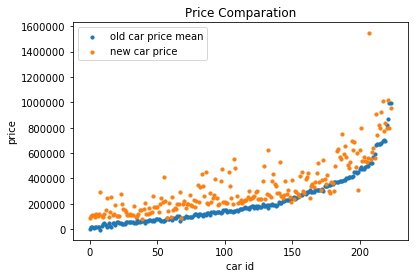

In [21]:
df_mean = df_mean.sort_values('old_price')
x = np.arange(len(df_mean))

y1 = df_mean['old_price'] - df_mean['old_coe']
y2 = df_mean['new_price']

plt.scatter(x, y1,label='old car price mean',s=10)
plt.scatter(x, y2,label='new car price',s=10)
plt.title('Price Comparation')
plt.xlabel('car id')
plt.ylabel('price')
plt.legend(loc='upper left')
plt.legend()
plt.show()

### 2.3 Price Depreciation with different car makes

In [22]:
df_make = match_df.groupby(['old_car_make']).mean()
df_make = df_make.sort_values('price_loss_rate')
df_make = df_make.drop(columns=['old_car_id', 'new_car_id', 'manufactured', 'similarity'])
df_make = df_make.reset_index()
df_make

,old_car_make,old_price,old_coe,new_price,no_owners,used_years,price_loss_rate
0,lamborghini,901675.000000,37899.500000,8.180000e+05,1.750000,3.250000,-0.022643
1,skoda,113795.238095,37000.619048,8.409048e+04,1.095238,3.238095,0.024468
2,bentley,743640.000000,44827.900000,8.390000e+05,1.100000,4.200000,0.030963
3,aston,721600.000000,47384.666667,7.990000e+05,2.666667,3.666667,0.035889
4,porsche,375295.348837,52375.230620,4.999378e+05,2.211240,6.860465,0.041351
5,rolls-royce,560977.777778,37965.444444,1.544000e+06,3.666667,13.333333,0.049927
6,mercedes-benz,326999.135447,45129.175793,3.415790e+05,1.115274,2.686047,0.064676
7,maserati,225845.070423,54333.478873,5.031972e+05,2.915493,9.422535,0.069499
8,perodua,21800.000000,15988.000000,8.599900e+04,5.000000,12.000000,0.077701
9,audi,160513.157895,49972.921053,2.843811e+05,1.973684,6.973684,0.118022


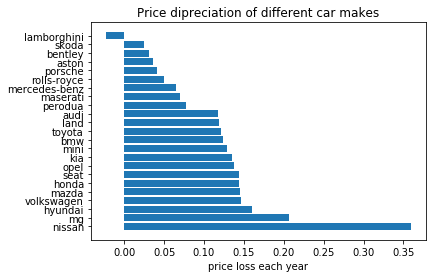

In [24]:
fig, ax = plt.subplots()

cars = df_make['old_car_make']
y_pos = np.arange(len(cars))

price_loss = df_make['price_loss_rate']

ax.barh(y_pos, price_loss, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(cars)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('price loss each year')
ax.set_title('Price dipreciation of different car makes')
plt.show()

### 2.4 Price Depreciation with different average used years
We noticed that Porsche and Honda have the largest number of matched old cars with new cars, with a number of `516` and `801` old cars for a certain type of new car respectively, which we regarded as convincing to conduct experiments. Therefore, we take porsche and honda as two examples to analysis the relationship between price depreciation with average used years.

### 2.4 a) Price depreciation with average used years (porsche)

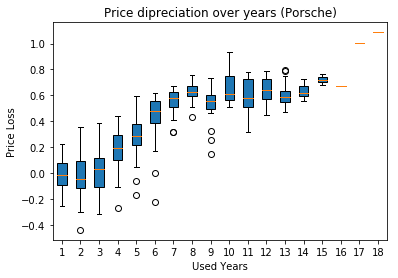

In [28]:
%%capture --no-display
porsche = match_df[match_df['old_car_make']=='porsche']
all_data = dict()
labels = list()
for keys, values in porsche.groupby('used_years'):
    all_data[keys] = values['price_loss_rate'].to_numpy() * values['used_years'].to_numpy()
    labels.append(round(keys))
plt.boxplot(all_data.values(), vert=True, patch_artist=True, labels=labels)

plt.xlabel('Used Years')
plt.ylabel('Price Loss')
plt.title('Price dipreciation over years (Porsche)')
plt.show()

### 2.4 b) Price depreciation with average used years (Honda)

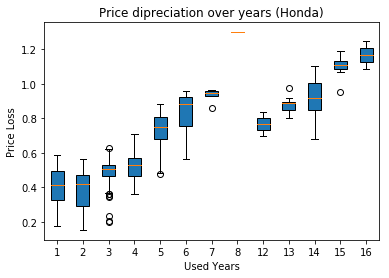

In [29]:
%%capture --no-display
honda = match_df[match_df['old_car_make']=='honda']
all_data = dict()
labels = list()
for keys, values in honda.groupby('used_years'):
    all_data[keys] = values['price_loss_rate'].to_numpy() * values['used_years'].to_numpy()
    labels.append(round(keys))
plt.boxplot(all_data.values(), vert=True, patch_artist=True, labels=labels)

plt.xlabel('Used Years')
plt.ylabel('Price Loss')
plt.title('Price dipreciation over years (Honda)')
plt.show()

### 2.5 Price Depreciation with different average number of owners
Intuition tells us that the more times an old car changes hands, the more discount. We take porsche and honda as two examples to verify our guess.

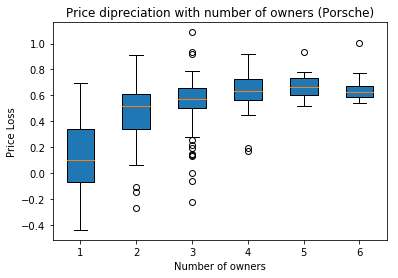

In [31]:
%%capture --no-display
all_data = dict()
labels = list()
for keys, values in porsche.groupby('no_owners'):
    all_data[keys] = values['price_loss_rate'].to_numpy() * values['used_years'].to_numpy()
    labels.append(round(keys))
plt.boxplot(all_data.values(), vert=True, patch_artist=True, labels=labels)

plt.xlabel('Number of owners')
plt.ylabel('Price Loss')
plt.title('Price dipreciation with number of owners (Porsche)')
plt.show()

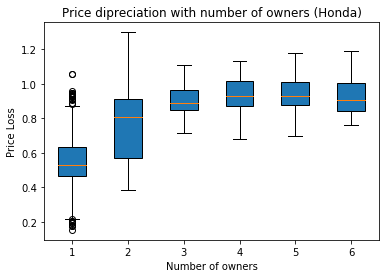

In [32]:
%%capture --no-display
all_data = dict()
labels = list()
for keys, values in honda.groupby('no_owners'):
    all_data[keys] = values['price_loss_rate'].to_numpy() * values['used_years'].to_numpy()
    labels.append(round(keys))
plt.boxplot(all_data.values(), vert=True, patch_artist=True, labels=labels)

plt.xlabel('Number of owners')
plt.ylabel('Price Loss')
plt.title('Price dipreciation with number of owners (Honda)')
plt.show()